In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from typing import List, Dict, Optional, Union, Tuple
import os
import logging
from google.cloud import bigquery

# For local VS Code authentication, use Application Default Credentials
# Make sure you've run: gcloud auth application-default login
# Or set GOOGLE_APPLICATION_CREDENTIALS environment variable

# Parameters
bq_project = 'syb-production-analytics'

# Configure logging for production environments
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

In [2]:
query = f"""
WITH paying_zone_measures AS (
  SELECT
    measure,
    partition_date,
    SUM(value) AS value
  FROM `syb-production-analytics.StatisticalProcessControl.SPCKeyMetricsDaily`
  WHERE measure LIKE '%nr_paying_sound_zones'
    AND measure NOT LIKE '%__eo%'
  GROUP BY ALL
),

max_date AS (
  SELECT MAX(partition_date) AS partition_date
  FROM paying_zone_measures
),

dim_measure AS (
  SELECT measure
  FROM paying_zone_measures
  GROUP BY 1
)

SELECT
  SPLIT(dm.measure, 'day__')[SAFE_OFFSET(1)] AS measure,
  partition_date,
  COALESCE(pzm.value, 0) AS value
FROM dim_measure dm
CROSS JOIN max_date md
CROSS JOIN
  UNNEST(
    GENERATE_DATE_ARRAY(
      DATE_ADD(md.partition_date, INTERVAL - 27 DAY),
      md.partition_date
    )
  ) AS partition_date
LEFT JOIN paying_zone_measures pzm USING (
  measure,
  partition_date
)
"""

In [3]:
client = bigquery.Client(bq_project)
df = client.query(query).to_dataframe()

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [34]:
from dataclasses import dataclass, field
from typing import List, Dict, Optional
import json

@dataclass
class SPCConfig:
    """Configuration for SPC Analysis and Reporting."""
    
    metric_column: str = 'measure'
    value_column: str = 'value'
    date_column: str = 'partition_date'
    
    metric_labels: Dict[str, str] = field(default_factory=lambda: {
        'churned__nr_paying_sound_zones': 'Churned Sound Zones',
        'new__nr_paying_sound_zones': 'New Sound Zones',
        'resubscribed__nr_paying_sound_zones': 'Resubscribed Sound Zones',
        'upsell__nr_paying_sound_zones': 'Upsell Sound Zones',
    })
    
    rules_active: List[int] = field(default_factory=lambda: [1, 2, 3, 4, 5])
    min_data_points: int = 10
    
    report_title: str = "Weekly SPC Report"
    team_name: str = "SPC Analysis System"
    
    colors: Dict[str, str] = field(default_factory=lambda: {
        'primary': '#000000',
        'mean_line': '#9E6EFF',
        'control_limits': '#F23440',
        'zone_lines': '#D6C2FF',
        'background': '#F5F4F5',
        'chart_bg': '#FFFFFF',
    })
    
    rule_colors: Dict[str, str] = field(default_factory=lambda: {
        'rule_1': '#F23440',
        'rule_2': '#FF9800',
        'rule_3': '#9E6EFF',
        'rule_4': '#1976D2',
        'rule_5': '#00897B',
    })
    
    def get_metric_label(self, metric_name: str) -> str:
        if metric_name in self.metric_labels:
            return self.metric_labels[metric_name]
        return metric_name.replace('_', ' ').replace('  ', ' ').title()


WESTERN_ELECTRIC_RULES = {
    'rule_1': {
        'name': 'Rule 1: Beyond 3σ',
        'short': 'R1: >3σ',
        'description': 'A single point falls outside the 3σ control limits',
        'business_explanation': 'an extreme value outside normal operating range (beyond 3σ)',
        'severity': 'critical',
        'action': 'Investigate immediately — likely a special cause event',
    },
    'rule_2': {
        'name': 'Rule 2: 2 of 3 Beyond 2σ',
        'short': 'R2: 2/3 >2σ',
        'description': '2 out of 3 consecutive points fall beyond 2σ on the same side',
        'business_explanation': 'unusual clustering near warning limits (2 of 3 points beyond 2σ)',
        'severity': 'high',
        'action': 'Monitor closely — early warning of potential shift',
    },
    'rule_3': {
        'name': 'Rule 3: 4 of 5 Beyond 1σ',
        'short': 'R3: 4/5 >1σ',
        'description': '4 out of 5 consecutive points fall beyond 1σ on the same side',
        'business_explanation': 'a subtle but persistent shift pattern (4 of 5 points beyond 1σ)',
        'severity': 'medium',
        'action': 'Investigate if pattern continues — possible small shift',
    },
    'rule_4': {
        'name': 'Rule 4: 8 Consecutive Same Side',
        'short': 'R4: 8 same side',
        'description': '8 consecutive points fall on the same side of the center line',
        'business_explanation': 'a sustained shift in the process level (8 consecutive points on same side)',
        'severity': 'high',
        'action': 'Process mean has likely shifted — investigate root cause',
    },
    'rule_5': {
        'name': 'Rule 5: 6 Consecutive Trending',
        'short': 'R5: 6 trending',
        'description': '6 consecutive points trending in the same direction',
        'business_explanation': 'a consistent directional trend (6+ consecutive movements)',
        'severity': 'medium',
        'action': 'Monitor trend — may indicate gradual process change',
    },
    'mr_violation': {
        'name': 'MR Violation: Beyond UCL',
        'short': 'MR > UCL',
        'description': 'Moving Range exceeds Upper Control Limit',
        'business_explanation': 'unusual volatility between consecutive data points',
        'severity': 'high',
        'action': 'Investigate sudden change — check for data quality or real event',
    },
}


class SPCAnalyzer:
    """Statistical Process Control (SPC) Analysis Engine."""
    
    def __init__(self, df: pd.DataFrame, config: SPCConfig):
        self.df = df.copy()
        self.config = config
        self._validate_columns()
        self._preprocess_data()
    
    def _validate_columns(self):
        required = [self.config.value_column, self.config.date_column]
        if self.config.metric_column:
            required.append(self.config.metric_column)
        
        missing = [col for col in required if col not in self.df.columns]
        if missing:
            raise ValueError(f"Missing required columns: {missing}")
    
    def _preprocess_data(self):
        self.df[self.config.date_column] = pd.to_datetime(self.df[self.config.date_column])
        self.df[self.config.value_column] = pd.to_numeric(self.df[self.config.value_column], errors='coerce')
        self.df = self.df.sort_values(self.config.date_column)
    
    def _calculate_limits(self, series: pd.Series) -> Dict[str, float]:
        mr_series = series.diff().abs()
        mean_x = series.mean()
        mean_mr = mr_series.mean()
        sigma_est = mean_mr / 1.128 if mean_mr != 0 else 0
        
        return {
            'mean': mean_x,
            'std': sigma_est,
            'ucl_x': mean_x + (3 * sigma_est),
            'lcl_x': mean_x - (3 * sigma_est),
            'mean_mr': mean_mr,
            'ucl_mr': 3.267 * mean_mr,
        }
    
    def _check_rules(self, series: pd.Series, mean: float, std: float) -> pd.DataFrame:
        if std == 0:
            return pd.DataFrame(False, index=series.index, 
                              columns=[f'rule_{r}' for r in self.config.rules_active])
        
        z = (series - mean) / std
        flags = pd.DataFrame(index=series.index)
        
        if 1 in self.config.rules_active:
            flags['rule_1'] = z.abs() > 3
        
        if 2 in self.config.rules_active:
            gt_2sig = (z > 2).astype(int).rolling(3).sum() >= 2
            lt_2sig = (z < -2).astype(int).rolling(3).sum() >= 2
            flags['rule_2'] = gt_2sig | lt_2sig
        
        if 3 in self.config.rules_active:
            gt_1sig = (z > 1).astype(int).rolling(5).sum() >= 4
            lt_1sig = (z < -1).astype(int).rolling(5).sum() >= 4
            flags['rule_3'] = gt_1sig | lt_1sig
        
        if 4 in self.config.rules_active:
            r4_pos = (z > 0).astype(int).rolling(8).sum() == 8
            r4_neg = (z < 0).astype(int).rolling(8).sum() == 8
            flags['rule_4'] = r4_pos | r4_neg
        
        if 5 in self.config.rules_active:
            diffs = series.diff()
            r5_inc = (diffs > 0).astype(int).rolling(5).sum() == 5
            r5_dec = (diffs < 0).astype(int).rolling(5).sum() == 5
            flags['rule_5'] = r5_inc | r5_dec
        
        return flags.fillna(False)
    
    def run_analysis(self) -> Dict:
        results = {}
        
        if self.config.metric_column and self.config.metric_column in self.df.columns:
            groups = self.df.groupby(self.config.metric_column)
        else:
            groups = [('all_data', self.df)]
        
        for name, group in groups:
            group_label = str(name)
            clean_group = group.dropna(subset=[self.config.value_column]).copy()
            
            if len(clean_group) < self.config.min_data_points:
                continue
            
            stats = self._calculate_limits(clean_group[self.config.value_column])
            rule_flags = self._check_rules(clean_group[self.config.value_column], stats['mean'], stats['std'])
            
            clean_group['moving_range'] = clean_group[self.config.value_column].diff().abs()
            clean_group['mr_anomaly'] = clean_group['moving_range'] > stats['ucl_mr']
            
            processed_df = pd.concat([clean_group, rule_flags], axis=1)
            
            rule_cols = [c for c in rule_flags.columns if c.startswith('rule_')]
            if rule_cols:
                processed_df['is_anomaly_x'] = processed_df[rule_cols].any(axis=1)
                processed_df['violation_labels_x'] = processed_df[rule_cols].apply(
                    lambda row: ",".join([c.replace('rule_', 'R') for c in rule_cols if row[c]]), axis=1
                )
            else:
                processed_df['is_anomaly_x'] = False
                processed_df['violation_labels_x'] = ""
            
            results[group_label] = {
                'data': processed_df,
                'stats': stats,
                'metric_name': group_label,
                'friendly_name': self.config.get_metric_label(group_label),
            }
        
        return results


class SPCChartGenerator:
    """Generates XmR control charts with brand styling."""
    
    def __init__(self, config: SPCConfig):
        self.config = config
    
    def _format_value(self, val: float) -> str:
        if abs(val) >= 1000:
            return f"{val:,.0f}"
        elif abs(val) >= 10:
            return f"{val:.1f}"
        else:
            return f"{val:.2f}"
    
    def plot_metric(self, data: Dict, save_path: Optional[str] = None) -> plt.Figure:
        df = data['data']
        stats = data['stats']
        friendly_name = data['friendly_name']
        
        date_col = self.config.date_column
        value_col = self.config.value_column
        
        fig, (ax_x, ax_mr) = plt.subplots(2, 1, figsize=(14, 10), sharex=True,
                                          gridspec_kw={'height_ratios': [3, 1]})
        
        fig.patch.set_facecolor(self.config.colors['background'])
        for ax in [ax_x, ax_mr]:
            ax.set_facecolor(self.config.colors['chart_bg'])
            for spine in ax.spines.values():
                spine.set_visible(False)
            ax.tick_params(colors=self.config.colors['primary'], labelsize=9)
        
        ax_x.tick_params(axis='x', which='both', length=0, labelbottom=False)
        
        ax_x.plot(df[date_col], df[value_col], 
                  color=self.config.colors['primary'],
                  linewidth=1.5, marker='o', markersize=4, zorder=3, label='Value')
        
        ax_x.axhline(stats['mean'], color=self.config.colors['mean_line'], 
                     linewidth=2, label='X̄ (Mean)')
        ax_x.axhline(stats['ucl_x'], color=self.config.colors['control_limits'], 
                     linestyle='--', linewidth=1.5, label='UCL / LCL (±3σ)')
        ax_x.axhline(stats['lcl_x'], color=self.config.colors['control_limits'], 
                     linestyle='--', linewidth=1.5)
        
        sigma = stats['std']
        ax_x.axhline(stats['mean'] + 1.5 * sigma, color=self.config.colors['zone_lines'], 
                     linestyle=':', alpha=0.8, linewidth=1, label='±1.5σ')
        ax_x.axhline(stats['mean'] - 1.5 * sigma, color=self.config.colors['zone_lines'], 
                     linestyle=':', alpha=0.8, linewidth=1)
        
        rule_cols = sorted([c for c in df.columns if c.startswith('rule_')])
        plotted_points = set()
        
        for rule_col in rule_cols:
            rule_points = df[df[rule_col] == True]
            if rule_points.empty:
                continue
            
            new_points = rule_points[~rule_points.index.isin(plotted_points)]
            if new_points.empty:
                continue
            
            color = self.config.rule_colors.get(rule_col, self.config.colors['control_limits'])
            label = WESTERN_ELECTRIC_RULES.get(rule_col, {}).get('short', rule_col)
            
            ax_x.scatter(new_points[date_col], new_points[value_col],
                        color=color, s=100, zorder=10 + rule_cols.index(rule_col),
                        marker='o', edgecolors='white', linewidths=1, label=label)
            plotted_points.update(new_points.index)
        
        anomalies_x = df[df['is_anomaly_x']]
        for _, row in anomalies_x.iterrows():
            triggered = sorted([c for c in rule_cols if row.get(c, False)])
            if triggered:
                primary_rule = triggered[0]
                color = self.config.rule_colors.get(primary_rule, self.config.colors['control_limits'])
                val_str = self._format_value(row[value_col])
                label_text = f"{row['violation_labels_x']}\n({val_str})"
                ax_x.annotate(label_text, (row[date_col], row[value_col]),
                             xytext=(0, 14), textcoords='offset points',
                             ha='center', fontsize=7, color=color, fontweight='bold')
        
        ax_x.set_title(f"XmR Chart: {friendly_name}", fontsize=14, fontweight='bold', 
                       color=self.config.colors['primary'], pad=15)
        ax_x.legend(loc='upper left', bbox_to_anchor=(1.01, 1), fontsize=8, frameon=False)
        
        ax_mr.plot(df[date_col], df['moving_range'], color=self.config.colors['primary'],
                   linewidth=1.5, marker='o', markersize=4, label='Moving Range', zorder=3)
        ax_mr.axhline(stats['mean_mr'], color=self.config.colors['mean_line'], 
                      linewidth=1.5, label='MR̄ (Mean)')
        ax_mr.axhline(stats['ucl_mr'], color=self.config.colors['control_limits'], 
                      linestyle='--', linewidth=1.5, label='UCL MR')
        
        anomalies_mr = df[df['mr_anomaly']]
        if not anomalies_mr.empty:
            ax_mr.scatter(anomalies_mr[date_col], anomalies_mr['moving_range'],
                         color=self.config.rule_colors['rule_1'], s=90, zorder=10,
                         marker='o', edgecolors='white', linewidths=1, label='R1: MR > UCL')
            for _, row in anomalies_mr.iterrows():
                val_str = self._format_value(row['moving_range'])
                ax_mr.annotate(f"R1\n({val_str})", (row[date_col], row['moving_range']),
                              xytext=(0, 12), textcoords='offset points',
                              ha='center', fontsize=7, color=self.config.rule_colors['rule_1'], fontweight='bold')
        
        ax_mr.legend(loc='upper left', bbox_to_anchor=(1.01, 1), fontsize=8, frameon=False)
        
        ax_mr.xaxis.set_major_formatter(mdates.DateFormatter('%b %-d'))
        ax_mr.xaxis.set_major_locator(mdates.DayLocator(interval=3))
        fig.autofmt_xdate(rotation=30, ha='right')
        
        plt.tight_layout()
        
        if save_path:
            fig.savefig(save_path, dpi=150, bbox_inches='tight', 
                       facecolor=self.config.colors['background'])
            plt.close(fig)
            return None
        
        return fig
    
    def plot_all(self, results: Dict, save_dir: Optional[str] = None) -> Dict[str, plt.Figure]:
        figures = {}
        
        if save_dir and not os.path.exists(save_dir):
            os.makedirs(save_dir)
        
        for metric_name, data in results.items():
            if save_dir:
                safe_name = "".join([c if c.isalnum() else "_" for c in metric_name])
                path = os.path.join(save_dir, f"SPC_{safe_name}.png")
                self.plot_metric(data, save_path=path)
            else:
                figures[metric_name] = self.plot_metric(data)
        
        return figures


class SPCCommentaryGenerator:
    """Generates natural-language commentary from SPC results."""
    
    def __init__(self, results: Dict, config: SPCConfig):
        self.results = results
        self.config = config
    
    def _assess_status(self, data: Dict) -> str:
        df = data['data']
        has_r1 = df.get('rule_1', pd.Series([False])).any()
        mr_anomalies = df['mr_anomaly'].sum()
        x_anomalies = df['is_anomaly_x'].sum()
        
        if has_r1 or mr_anomalies > 1:
            return 'alert'
        elif x_anomalies > 0:
            return 'warning'
        return 'stable'
    
    def _get_triggered_rules(self, data: Dict) -> List[Dict]:
        df = data['data']
        triggered = []
        
        rule_cols = [c for c in df.columns if c.startswith('rule_')]
        for rule_col in rule_cols:
            if df[rule_col].any():
                rule_info = WESTERN_ELECTRIC_RULES.get(rule_col, {})
                triggered_rows = df[df[rule_col]]
                
                triggered.append({
                    'rule': rule_col,
                    'name': rule_info.get('name', rule_col),
                    'short': rule_info.get('short', rule_col),
                    'description': rule_info.get('description', ''),
                    'business_explanation': rule_info.get('business_explanation', ''),
                    'severity': rule_info.get('severity', 'medium'),
                    'action': rule_info.get('action', ''),
                    'count': int(df[rule_col].sum()),
                    'dates': triggered_rows[self.config.date_column].dt.strftime('%b %d').tolist(),
                    'values': triggered_rows[self.config.value_column].tolist(),
                })
        
        if df['mr_anomaly'].any():
            mr_info = WESTERN_ELECTRIC_RULES.get('mr_violation', {})
            mr_rows = df[df['mr_anomaly']]
            triggered.append({
                'rule': 'mr_violation',
                'name': mr_info.get('name', 'MR Violation'),
                'short': mr_info.get('short', 'MR > UCL'),
                'description': mr_info.get('description', ''),
                'business_explanation': mr_info.get('business_explanation', ''),
                'severity': mr_info.get('severity', 'high'),
                'action': mr_info.get('action', ''),
                'count': int(df['mr_anomaly'].sum()),
                'dates': mr_rows[self.config.date_column].dt.strftime('%b %d').tolist(),
                'values': mr_rows['moving_range'].tolist(),
            })
        
        return triggered
    
    def generate_metric_summary(self, metric_name: str) -> Dict:
        data = self.results[metric_name]
        df = data['data']
        stats = data['stats']
        friendly_name = data['friendly_name']
        
        status = self._assess_status(data)
        triggered_rules = self._get_triggered_rules(data)
        
        current_val = df[self.config.value_column].iloc[-1]
        z_score = (current_val - stats['mean']) / stats['std'] if stats['std'] > 0 else 0
        position = "at average" if abs(z_score) < 0.5 else ("above average" if z_score > 0 else "below average")
        
        return {
            'metric_name': metric_name,
            'friendly_name': friendly_name,
            'status': status,
            'status_emoji': {'alert': '🚨', 'warning': '⚠️', 'stable': '✅'}[status],
            'current_value': float(current_val),
            'position': position,
            'mean': float(stats['mean']),
            'ucl': float(stats['ucl_x']),
            'lcl': float(stats['lcl_x']),
            'std': float(stats['std']),
            'triggered_rules': triggered_rules,
            'is_stable': len(triggered_rules) == 0,
            'recent_values': df[self.config.value_column].tail(7).tolist(),
        }
    
    def generate_all_summaries(self) -> List[Dict]:
        summaries = [self.generate_metric_summary(name) for name in self.results.keys()]
        status_order = {'alert': 0, 'warning': 1, 'stable': 2}
        return sorted(summaries, key=lambda x: status_order[x['status']])
    
    def format_slack_message(self, summaries: List[Dict], executive_summary: Optional[str] = None) -> str:
        from datetime import datetime
        today = datetime.now().strftime('%B %d, %Y')
        
        lines = [f"📊 *{self.config.report_title} — {today}*", ""]
        
        if executive_summary:
            lines.extend(["*Executive Summary*", executive_summary, ""])
        
        lines.append("─" * 40)
        
        for s in summaries:
            lines.append("")
            lines.append(f"{s['status_emoji']} *{s['friendly_name']}*: {s['current_value']:,.0f} ({s['position']})")
            lines.append(f"   Mean: {s['mean']:,.1f} | Limits: [{s['lcl']:,.1f}, {s['ucl']:,.1f}]")
            
            if s['triggered_rules']:
                for rule in s['triggered_rules']:
                    lines.append(f"   • *{rule['short']}* on {', '.join(rule['dates'][-3:])} — {rule['business_explanation']}")
            else:
                lines.append("   • No signals detected — process is stable")
        
        lines.append("")
        lines.append("─" * 40)
        lines.append("")
        lines.append("*Western Electric Rules Reference:*")
        for rule_key in ['rule_1', 'rule_2', 'rule_3', 'rule_4', 'rule_5']:
            if int(rule_key.split('_')[1]) in self.config.rules_active:
                rule = WESTERN_ELECTRIC_RULES[rule_key]
                lines.append(f"• {rule['short']}: {rule['description']}")
        
        lines.append("")
        lines.append(f"_Generated by {self.config.team_name}_")
        
        return "\n".join(lines)
    
    def prepare_llm_context(self) -> str:
        summaries = self.generate_all_summaries()
        return json.dumps(summaries, indent=2, default=str)
    
    def build_llm_prompt(self) -> str:
        context = self.prepare_llm_context()
        rules_ref = "\n".join([
            f"- {WESTERN_ELECTRIC_RULES[f'rule_{i}']['short']}: {WESTERN_ELECTRIC_RULES[f'rule_{i}']['description']}"
            for i in self.config.rules_active
        ])
        
        return f"""You are a senior business analyst writing the weekly metrics report for leadership.

CONTEXT:
- These are Statistical Process Control (SPC) metrics
- Signals indicate when a metric is behaving unusually (outside normal variation)
- Rules reference:
{rules_ref}
- MR_violation = unusual volatility between consecutive data points

METRICS DATA:
{context}

TASK:
Write a concise executive summary (3-5 sentences max) that:
1. Opens with overall health assessment (how many metrics stable vs concerning)
2. Highlights the 1-2 most important findings that need attention
3. Provides brief business context (what this might mean)
4. Ends with a clear action item or reassurance

STYLE:
- Be direct and specific, not vague
- Use numbers when relevant
- Avoid jargon — explain in business terms
- Sound like a thoughtful analyst, not a robot
- Format for Slack (use *bold* for emphasis)

Write only the executive summary, nothing else."""


def run_spc_analysis(df: pd.DataFrame, config: Optional[SPCConfig] = None) -> Dict:
    """Run complete SPC analysis pipeline."""
    if config is None:
        config = SPCConfig()
    
    analyzer = SPCAnalyzer(df, config)
    results = analyzer.run_analysis()
    
    chart_gen = SPCChartGenerator(config)
    figures = chart_gen.plot_all(results)
    
    for metric_name in results:
        if metric_name in figures:
            results[metric_name]['figure'] = figures[metric_name]
    
    commentary_gen = SPCCommentaryGenerator(results, config)
    
    return {
        'results': results,
        'figures': figures,
        'commentary': commentary_gen,
        'config': config,
    }


config = SPCConfig(
    metric_column='measure',
    value_column='value',
    date_column='partition_date',
    metric_labels={
        'churned__nr_paying_sound_zones': 'Churned Sound Zones',
        'new__nr_paying_sound_zones': 'New Sound Zones',
        'resubscribed__nr_paying_sound_zones': 'Resubscribed Sound Zones',
        'upsell__nr_paying_sound_zones': 'Upsell Sound Zones',
    },
    report_title="Weekly SPC Report",
    team_name="Soundtrack Analytics",
)

print("✅ SPC Module loaded")
print(f"   Active rules: {config.rules_active}")

✅ SPC Module loaded
   Active rules: [1, 2, 3, 4, 5]


✅ Analysis complete for 4 metrics:
   🚨 Churned Sound Zones
   ⚠️ New Sound Zones
   🚨 Resubscribed Sound Zones
   ✅ Upsell Sound Zones


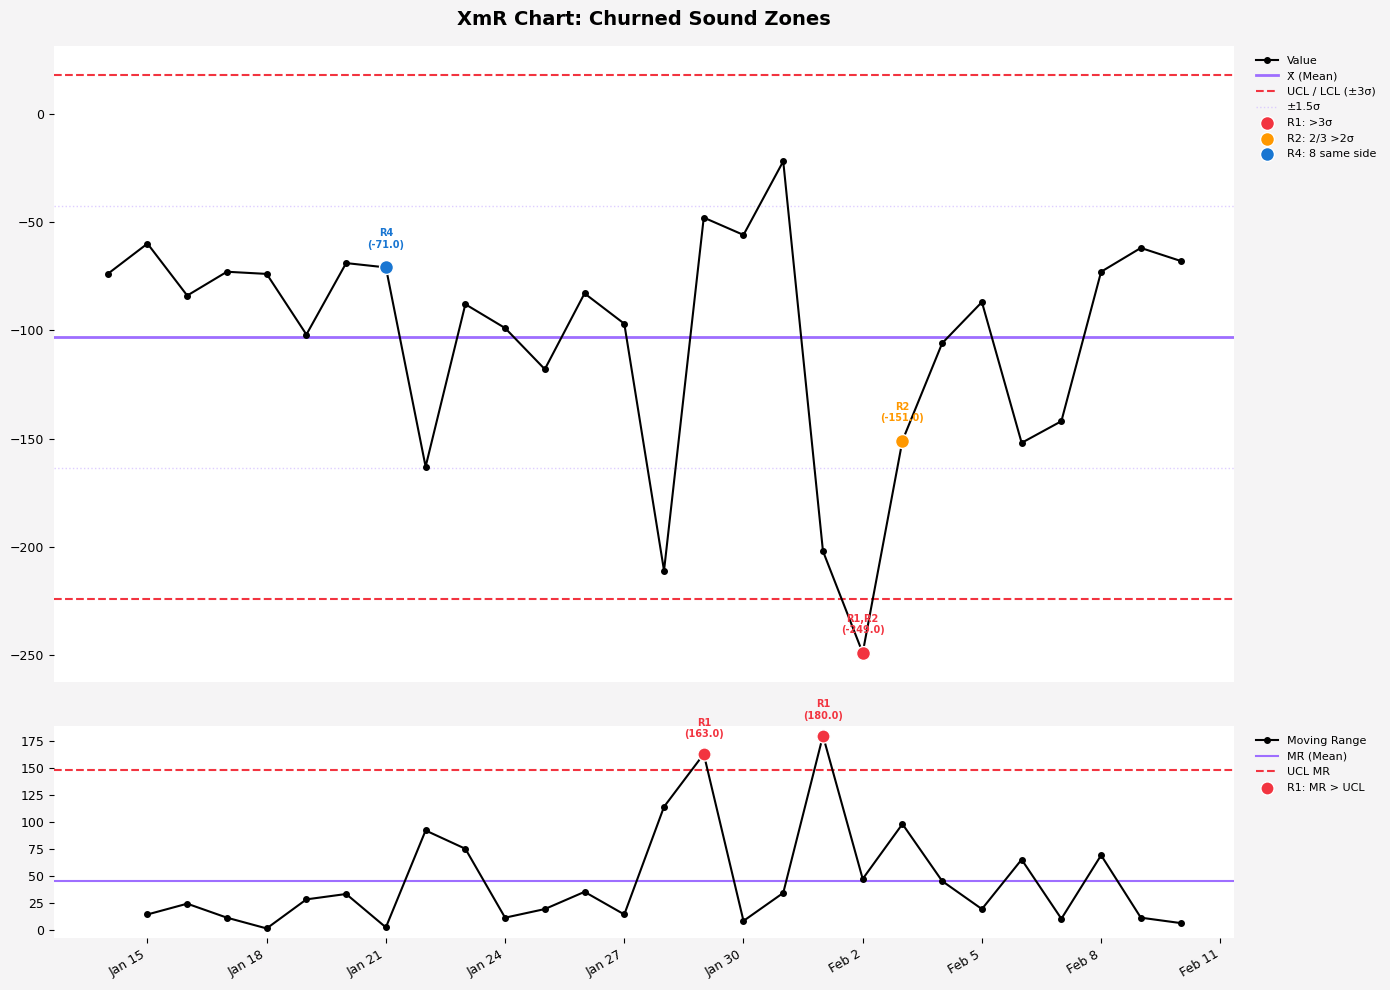

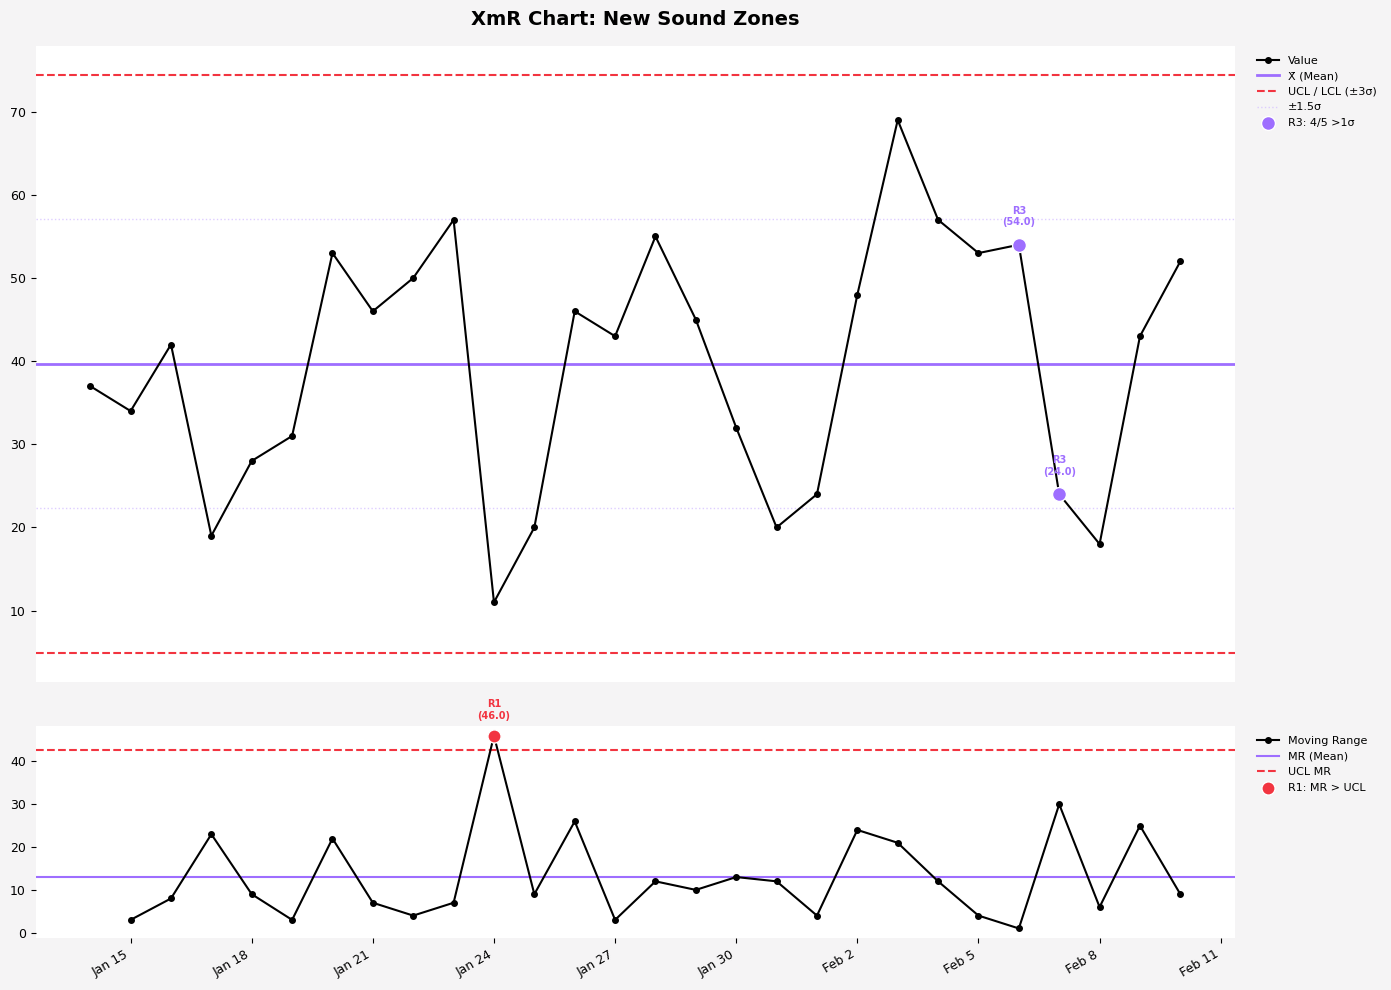

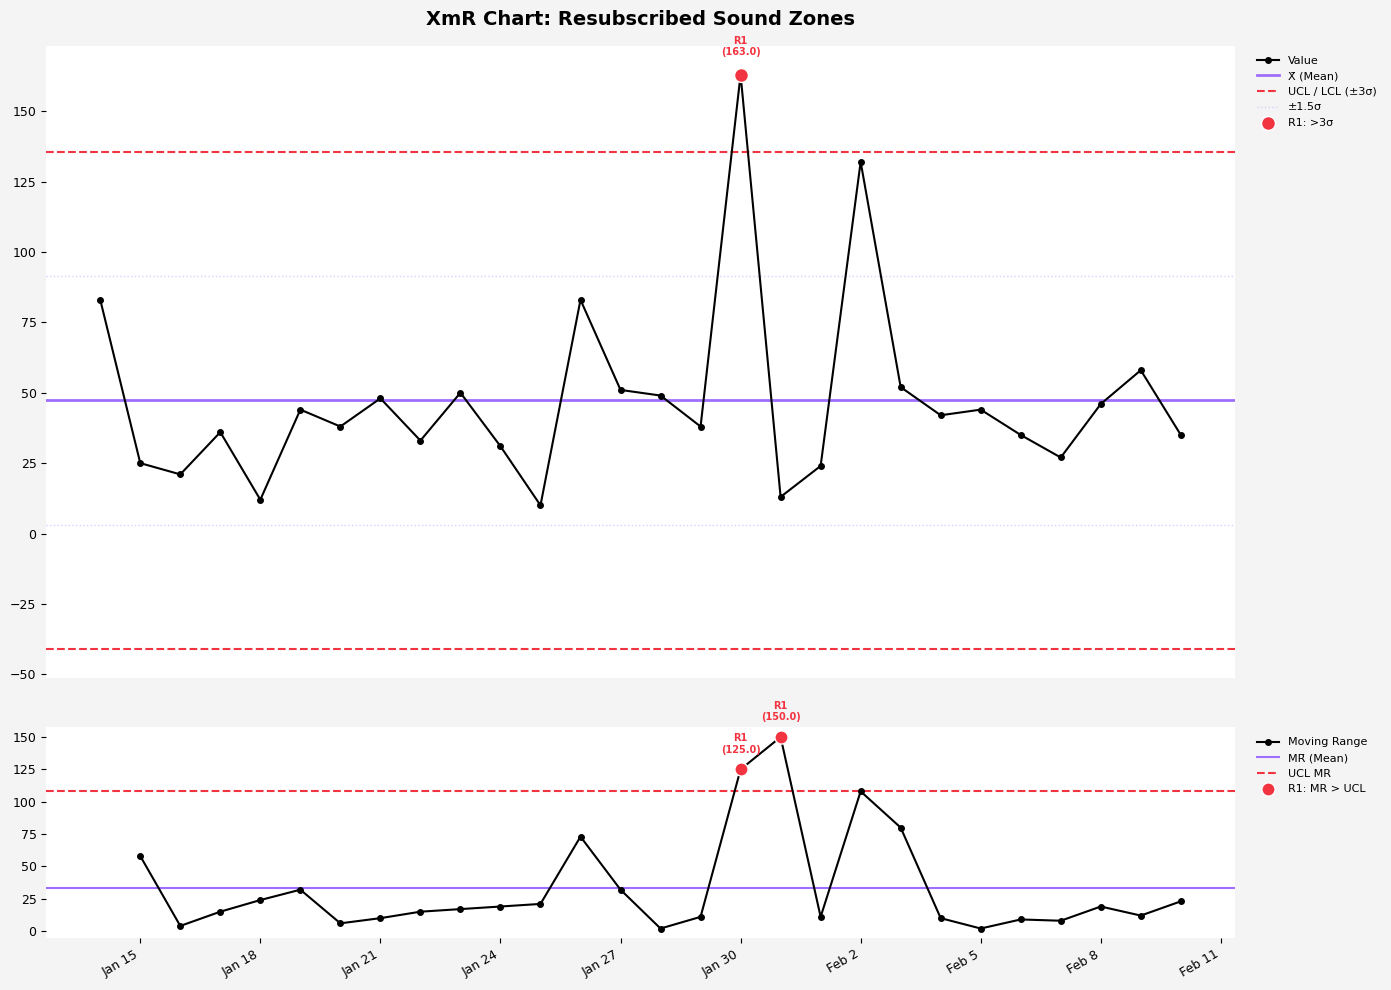

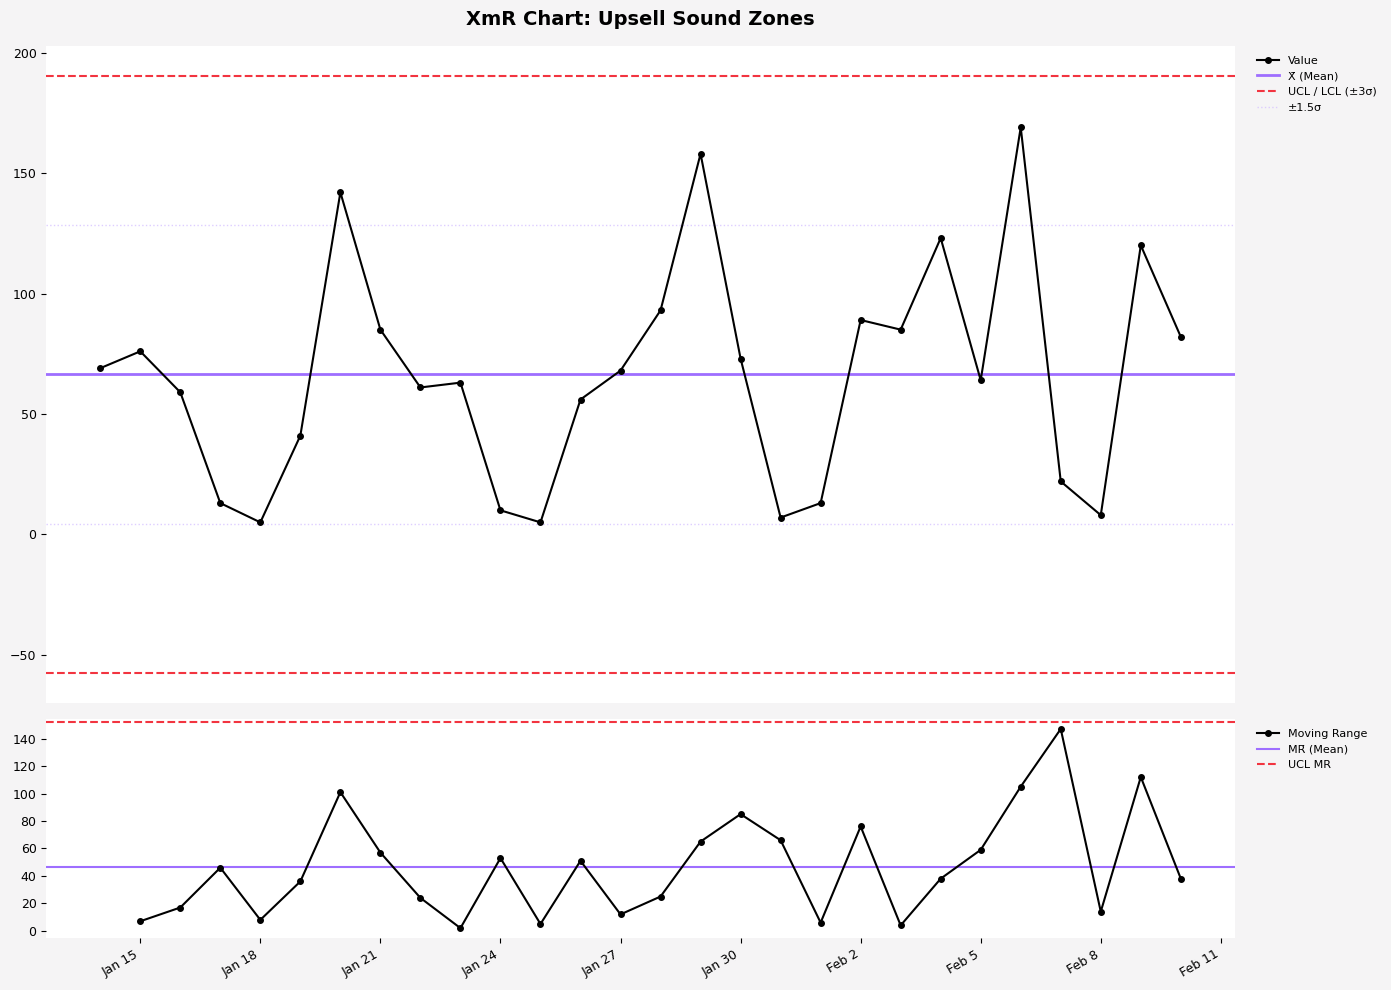

In [35]:
# =============================================================================
# RUN SPC ANALYSIS
# =============================================================================

# Run the complete analysis pipeline
output = run_spc_analysis(df, config)

# Extract components
results = output['results']
figures = output['figures']
commentary = output['commentary']

print(f"✅ Analysis complete for {len(results)} metrics:")
for name, data in results.items():
    status = commentary._assess_status(data)
    emoji = {'alert': '🚨', 'warning': '⚠️', 'stable': '✅'}[status]
    print(f"   {emoji} {data['friendly_name']}")

# Display the charts
for fig in figures.values():
    plt.show()

In [6]:
# =============================================================================
# VIEW ANOMALIES DATA
# =============================================================================
# Access the detailed data for any metric

# Get all anomalies across all metrics
all_anomalies = []
for metric_name, data in results.items():
    df_metric = data['data']
    anomalies = df_metric[df_metric['is_anomaly_x'] | df_metric['mr_anomaly']].copy()
    anomalies['metric'] = data['friendly_name']
    all_anomalies.append(anomalies)

if all_anomalies:
    anomalies_df = pd.concat(all_anomalies, ignore_index=True)
    display_cols = ['metric', config.date_column, config.value_column, 'moving_range', 
                    'violation_labels_x', 'mr_anomaly']
    # Add rule columns that exist
    rule_cols = [f'rule_{i}' for i in config.rules_active if f'rule_{i}' in anomalies_df.columns]
    display_cols.extend(rule_cols)
    
    print(f"📋 All Anomalies ({len(anomalies_df)} total):")
    anomalies_df[display_cols]
else:
    print("✅ No anomalies detected across all metrics!")

📋 All Anomalies (10 total):


In [7]:
# =============================================================================
# GENERATE TEMPLATE-BASED REPORT
# =============================================================================
# This generates the full Slack message using rule-based templates (no LLM needed)

summaries = commentary.generate_all_summaries()
slack_message = commentary.format_slack_message(summaries)

print(slack_message)

📊 *Weekly SPC Report — February 11, 2026*

────────────────────────────────────────

🚨 *Churned Sound Zones*: -68 (above average)
   Mean: -103.0 | Limits: [-224.0, 18.0]
   • *R1: >3σ* on Feb 02 — an extreme value outside normal operating range (beyond 3σ)
   • *R2: 2/3 >2σ* on Feb 02, Feb 03 — unusual clustering near warning limits (2 of 3 points beyond 2σ)
   • *R4: 8 same side* on Jan 21 — a sustained shift in the process level (8 consecutive points on same side)
   • *MR > UCL* on Jan 29, Feb 01 — unusual volatility between consecutive data points

🚨 *Resubscribed Sound Zones*: 35 (at average)
   Mean: 47.2 | Limits: [-41.0, 135.5]
   • *R1: >3σ* on Jan 30 — an extreme value outside normal operating range (beyond 3σ)
   • *MR > UCL* on Jan 30, Jan 31 — unusual volatility between consecutive data points

⚠️ *New Sound Zones*: 52 (above average)
   Mean: 39.7 | Limits: [4.9, 74.5]
   • *R3: 4/5 >1σ* on Feb 06, Feb 07 — a subtle but persistent shift pattern (4 of 5 points beyond 1σ)


In [8]:
# =============================================================================
# PREVIEW LLM PROMPT
# =============================================================================
# This shows what would be sent to the LLM for executive summary generation

prompt = commentary.build_llm_prompt()

print("=" * 70)
print("LLM PROMPT PREVIEW")
print("=" * 70)
print(prompt)

LLM PROMPT PREVIEW
You are a senior business analyst writing the weekly metrics report for leadership.

CONTEXT:
- These are Statistical Process Control (SPC) metrics
- Signals indicate when a metric is behaving unusually (outside normal variation)
- Rules reference:
- R1: >3σ: A single point falls outside the 3σ control limits
- R2: 2/3 >2σ: 2 out of 3 consecutive points fall beyond 2σ on the same side
- R3: 4/5 >1σ: 4 out of 5 consecutive points fall beyond 1σ on the same side
- R4: 8 same side: 8 consecutive points fall on the same side of the center line
- R5: 6 trending: 6 consecutive points trending in the same direction
- MR_violation = unusual volatility between consecutive data points

METRICS DATA:
[
  {
    "metric_name": "churned__nr_paying_sound_zones",
    "friendly_name": "Churned Sound Zones",
    "status": "alert",
    "status_emoji": "\ud83d\udea8",
    "current_value": -68.0,
    "position": "above average",
    "mean": -103.0,
    "ucl": 17.96138691883374,
    "lcl"

In [36]:
# =============================================================================
# LOAD SECRETS FROM .env FILE
# =============================================================================
from dotenv import load_dotenv
import os

# Load environment variables from .env file (force reload)
load_dotenv(override=True)

GOOGLE_CLOUD_PROJECT = os.environ.get('GOOGLE_CLOUD_PROJECT', bq_project)
GEMINI_API_KEY = os.environ.get('GEMINI_API_KEY')
SLACK_BOT_TOKEN = os.environ.get('SLACK_BOT_TOKEN')
SLACK_CHANNEL = os.environ.get('SLACK_CHANNEL', '#spc-reports')

print(f"Gemini API Key: {'✅' if GEMINI_API_KEY else '❌'}")
print(f"Slack Bot Token: {'✅' if SLACK_BOT_TOKEN else '❌'}")
print(f"Slack Channel: {SLACK_CHANNEL}")

Gemini API Key: ✅
Slack Bot Token: ✅
Slack Channel: #soundhack2026-reportbot


In [10]:
# =============================================================================
# CUSTOM PROMPT FOR SLACK-FRIENDLY BULLET FORMAT
# =============================================================================

def build_slack_bullet_prompt(commentary) -> str:
    """Build prompt that generates Slack-friendly bullet point summary."""
    context = commentary.prepare_llm_context()
    
    rules_ref = "\n".join([
        f"- {WESTERN_ELECTRIC_RULES[f'rule_{i}']['short']}: {WESTERN_ELECTRIC_RULES[f'rule_{i}']['description']}"
        for i in commentary.config.rules_active
    ])
    
    return f"""You are a senior business analyst writing a weekly metrics update for a Slack channel read by people at all levels (execs, managers, analysts).

CONTEXT:
- These are Statistical Process Control (SPC) metrics tracking sound zone subscriptions
- Signals indicate when a metric is behaving unusually (outside normal variation)
- Rules reference:
{rules_ref}
- MR_violation = unusual volatility between consecutive data points

METRICS DATA:
{context}

TASK:
Write a concise, scannable summary using this EXACT format:

*TL;DR: [X of Y metrics need attention]* 🔍

*🚨 Needs Investigation:*
• *[Metric Name]* — [one sentence: what happened, when, how bad]. *Action: [specific action]*
[repeat for each concerning metric]

*✅ Looking Good:*
• *[Metric Name]* — within normal range
[repeat for each stable metric]

*Next Steps:*
• [Most important action item]
• [Secondary action if needed]

STYLE RULES:
- Keep each bullet to ONE line max
- Use specific numbers and dates
- Be direct — this is for busy people scanning on mobile
- Use Slack formatting: *bold* for emphasis
- Sound human, not robotic
- If a metric is stable, just say "within normal range" — don't over-explain

Write ONLY the summary in the format above, nothing else."""


# Generate the prompt
custom_prompt = build_slack_bullet_prompt(commentary)
print("✅ Custom prompt built")
print(f"   Prompt length: {len(custom_prompt)} characters")

✅ Custom prompt built
   Prompt length: 7996 characters


In [37]:
# =============================================================================
# CALL GEMINI TO GENERATE SUMMARY
# =============================================================================

def generate_llm_summary_gemini(prompt: str, api_key: str = None, project: str = None) -> str:
    """
    Call Gemini API to generate the summary.
    
    Uses either:
    - Gemini API directly (if api_key provided)
    - Vertex AI (if project provided, uses ADC from gcloud auth)
    """
    
    if api_key:
        # Use google.genai (new SDK)
        from google import genai
        
        client = genai.Client(api_key=api_key)
        response = client.models.generate_content(
            model='gemini-2.0-flash',
            contents=prompt
        )
        return response.text
    
    elif project:
        # Use Vertex AI (works with your existing GCP auth)
        import vertexai
        from vertexai.generative_models import GenerativeModel
        
        vertexai.init(project=project, location="us-central1")
        model = GenerativeModel("gemini-2.0-flash")
        response = model.generate_content(prompt)
        return response.text
    
    else:
        raise ValueError("Provide either api_key or project")


# Generate the executive summary using Gemini
print("🤖 Calling Gemini to generate summary...")

try:
    if GEMINI_API_KEY:
        executive_summary = generate_llm_summary_gemini(custom_prompt, api_key=GEMINI_API_KEY)
    else:
        # Fall back to Vertex AI using your existing GCP credentials
        executive_summary = generate_llm_summary_gemini(custom_prompt, project=GOOGLE_CLOUD_PROJECT)
    
    print("✅ Summary generated!\n")
    print(executive_summary)
except Exception as e:
    print(f"❌ Error: {e}")
    print("\nTo fix this, either:")
    print("1. Set GEMINI_API_KEY from https://aistudio.google.com/apikey")
    print("2. Or ensure Vertex AI API is enabled in your GCP project")
    executive_summary = None

2026-02-11 17:00:37,341 - INFO - AFC is enabled with max remote calls: 10.


🤖 Calling Gemini to generate summary...


2026-02-11 17:00:39,377 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.0-flash:generateContent "HTTP/1.1 200 OK"


✅ Summary generated!

*TL;DR: 3 of 4 metrics need attention* 🔍

*🚨 Needs Investigation:*
• *Churned Sound Zones* — Multiple rule violations, including exceeding the 3σ limit on Feb 02. *Action: Investigate immediately for special cause event.*
• *Resubscribed Sound Zones* — Breached the 3σ limit on Jan 30. *Action: Investigate for likely special cause event.*
• *New Sound Zones* — Experiencing unusual volatility and a shift pattern, last flagged Feb 07. *Action: Investigate if pattern continues; possible small shift.*

*✅ Looking Good:*
• *Upsell Sound Zones* — within normal range

*Next Steps:*
• Investigate the churned sound zones data to determine root cause of deviations.
• Check the validity of data for Resubscribed & New Sound Zones.



In [38]:
import requests
import io

def upload_chart(headers: dict, fig, metric_name: str, config) -> str | None:
    """Upload a chart. Returns file_id."""
    buf = io.BytesIO()
    fig.savefig(buf, format='png', dpi=150, bbox_inches='tight', facecolor=config.colors['background'])
    buf.seek(0)
    content = buf.read()
    safe_name = "".join([c if c.isalnum() else "_" for c in metric_name])
    
    resp = requests.post("https://slack.com/api/files.getUploadURLExternal", headers=headers,
                        data={"filename": f"SPC_{safe_name}.png", "length": len(content)})
    if not resp.json().get("ok"):
        return None
    
    requests.post(resp.json()["upload_url"], files={"file": (f"SPC_{safe_name}.png", content, "image/png")})
    buf.close()
    return resp.json()["file_id"]


def resolve_channel_id(headers: dict, channel: str) -> str | None:
    """Get channel ID by posting and deleting a test message."""
    resp = requests.post("https://slack.com/api/chat.postMessage", headers=headers,
                        json={"channel": channel, "text": "..."})
    if resp.json().get("ok"):
        channel_id = resp.json()["channel"]
        # Delete the test message
        requests.post("https://slack.com/api/chat.delete", headers=headers,
                     json={"channel": channel_id, "ts": resp.json()["ts"]})
        return channel_id
    return None


def post_to_slack(bot_token: str, channel: str, message: str, figures: dict, config) -> bool:
    """Post message with charts attached to a single message."""
    headers = {"Authorization": f"Bearer {bot_token}"}
    
    # Upload charts
    file_ids = [{"id": fid, "title": f"XmR: {config.get_metric_label(n)}"}
                for n, fig in figures.items() if fig and (fid := upload_chart(headers, fig, n, config))]
    
    if not file_ids:
        resp = requests.post("https://slack.com/api/chat.postMessage", headers=headers,
                            json={"channel": channel, "text": message})
        print("✅ Posted" if resp.json().get("ok") else f"❌ {resp.json().get('error')}")
        return resp.json().get("ok", False)
    
    # Get channel ID
    channel_id = channel if channel.startswith("C") else resolve_channel_id(headers, channel)
    if not channel_id:
        print(f"❌ Cannot resolve channel: {channel}")
        return False
    
    # Complete upload with message
    resp = requests.post("https://slack.com/api/files.completeUploadExternal", headers=headers,
                        json={"files": file_ids, "channel_id": channel_id, "initial_comment": message})
    
    print(f"✅ Posted with {len(file_ids)} charts" if resp.json().get("ok") else f"❌ {resp.json().get('error')}")
    return resp.json().get("ok", False)


full_message = commentary.format_slack_message(summaries, executive_summary=executive_summary if executive_summary else None)
print(full_message)

📊 *Weekly SPC Report — February 11, 2026*

*Executive Summary*
*TL;DR: 3 of 4 metrics need attention* 🔍

*🚨 Needs Investigation:*
• *Churned Sound Zones* — Multiple rule violations, including exceeding the 3σ limit on Feb 02. *Action: Investigate immediately for special cause event.*
• *Resubscribed Sound Zones* — Breached the 3σ limit on Jan 30. *Action: Investigate for likely special cause event.*
• *New Sound Zones* — Experiencing unusual volatility and a shift pattern, last flagged Feb 07. *Action: Investigate if pattern continues; possible small shift.*

*✅ Looking Good:*
• *Upsell Sound Zones* — within normal range

*Next Steps:*
• Investigate the churned sound zones data to determine root cause of deviations.
• Check the validity of data for Resubscribed & New Sound Zones.


────────────────────────────────────────

🚨 *Churned Sound Zones*: -68 (above average)
   Mean: -103.0 | Limits: [-224.0, 18.0]
   • *R1: >3σ* on Feb 02 — an extreme value outside normal operating range (bey

In [ ]:
# ⚠️ Confirmation required before posting
confirm = input("\n⚠️  Post to Slack? (yes/y to confirm): ").strip().lower()

if confirm in ['yes', 'y']:
    if SLACK_BOT_TOKEN:
        post_to_slack(SLACK_BOT_TOKEN, SLACK_CHANNEL, full_message, figures, config)
    else:
        print("❌ Set SLACK_BOT_TOKEN in .env")
else:
    print("❌ Cancelled")

✅ Posted with 4 charts
